# Monitoring coastal erosion along Africa's coastline

* **Products used:**
[s1_rtc](https://explorer.digitalearth.africa/s1_rtc)

## Background
Over 40% of the world’s population lives within 100 km of the coastline. 
However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats. 
Up-to-date data on coastal change and erosion is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion.

While coastlines can be mapped using optical data (demonstrated in the [Coastal Erosion notebook](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/main/Real_world_examples/Coastal_erosion.ipynb)), these images can be strongly affected by the weather, especially through the presence of clouds, which obscure the land and water below. This can be a particular problem in cloudy regions or areas where wet season clouds prevent optical satellites from taking clear images for many months of the year.

### Sentinel-1 use case
Radar observations are largely unaffected by cloud cover, so can take reliable measurements of areas in any weather. Radar data is readily available from the ESA/EC Copernicus program’s Sentinel-1 satellites. The two satellites provide all-weather observations, with a revisit time of 6 days. By developing a process to classify the observed pixels as either water or land, it is possible to identify the shoreline from radar data.

### Description

In this example, we use a simplified version of the [DE Africa Coastlines](https://github.com/digitalearthafrica/deafrica-coastlines.git) method to combine data from Sentinel-1 satellite with image compositing and tide filtering techniques to accurately map shorelines across time, and identify areas that have changed significantly between 2018 and 2021. 
The worked example demonstrates how to:

1. Load Sentinel-1 backscatter data for an area of interest
2. Filter images by tide height to discard low and tide imagery
3. Perform pre-processing steps on the Sentinel-1 bands
4. Use histogram analysis to determine the threshold for land/water classification
5. Create "summary" or composite images for each year of data
6. Extract and visualise annual shorelines across time
7. Use these annual shorelines to calculate and visualise rates of coastal change

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
First we need to install additional tools from the [DE Africa Coastlines](https://github.com/digitalearthafrica/deafrica-coastlines.git) repository that will allow us to estimate rates of coastal change. 
> **Note:** If you run into any error messages in this analysis, try restarting the notebook by clicking `Kernel`, then `Restart Kernel and Clear All Outputs`.

In [35]:
pip install -q git+https://github.com/digitalearthafrica/deafrica-coastlines.git --disable-pip-version-check

Note: you may need to restart the kernel to use updated packages.


Now we can load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import sys
sys.path.insert(1, '../Tools/')

import os
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.coastal import model_tides, tidal_tag, pixel_tides, tidal_stats
from deafrica_tools.spatial import subpixel_contours
# from dea_tools.coastal import model_tides, tidal_tag, pixel_tides, tidal_stats
# from dea_tools.spatial import subpixel_contours
from deafrica_tools.plotting import display_map, rgb, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from coastlines.raster import tide_cutoffs,load_tidal_subset
from coastlines.vector import points_on_line, annual_movements, calculate_regressions

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.filters import threshold_minimum, threshold_otsu
from datacube.utils.cog import write_cog

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
client = create_local_dask_cluster(return_client=True)

<Client: 'tcp://127.0.0.1:43533' processes=1 threads=15, memory=104.37 GB>

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app="Coastal_erosion")

### Analysis parameters

The following cell set important parameters for the analysis:

* `lat`: The central latitude to analyse (e.g. `14.283`).
* `lon`: The central longitude to analyse (e.g. `-16.921`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2013', '2020') `)
* `time_step`: This parameter allows us to choose the length of the time periods we want to compare: e.g. shorelines for each year, or shorelines for each six months etc. 
`1Y` will generate one coastline for every year in the dataset; `6M` will produce a coastline for every six months, etc.
* `tide_range`: The minimum and maximum proportion of the tidal range to include in the analysis. 
For example, `tide_range = (0.50, 1.00)` will select all satellite images taken when the tide was greater than the median (i.e. 50th percentile) of all tide heights and less than the maximum (i.e. 100th percentile) of all tide heights. 
This allows you to seperate the effect of erosion from the influence of tides by producing shorelines for specific tidal conditions (e.g. low tide, average tide, high tide shorelines etc). 

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example explores coastal change in Ponto, Senegal. 

**To run the notebook for a different area**, make sure Sentinel-1 data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/).

To ensure that the tidal modelling part of this analysis works correctly, please make sure the **centre of the study area is located over water** when setting `lat_range` and `lon_range`.

In [16]:
# # Define the area of interest: Madagarscar
lat = -17.474
lon = 43.924

# # Define the area of interest: around Comoros
# lat = -12.4
# lon = 43.736

# Combine central lat,lon with buffer to get area of interest
buffer = 0.04
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

# Set the range of dates for the analysis, time step and tide range
time_range = ('2018', '2021')
time_step = '1Y'
tide_range = (0.25, 0.75)

# whether to implement Lee filtering
lee_filtering=True

# Lee filtering size
filter_size=2

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [6]:
display_map(x=lon_range, y=lat_range)

## Load Sentinel-1 data
The first step in this analysis is to load in Sentinel-1 data for the `lat_range`, `lon_range` and `time_range` we provided above. 
The code below uses the `load_ard` function to load in data from Sentinel-1 for the area and time specified. Sentinel-1 backscatter data has two measurements, VV and VH, which correspond to the polarisation of the light sent and received by the satellite. VV refers to the satellite sending out vertically-polarised light and receiving vertically-polarised light back, whereas VH refers to the satellite sending out vertically-polarised light and receiving horizontally-polarised light back. These two measurement bands can tell us different information about the area we’re studying. We also load the band mask layer,. The values 0, 1 and 2 in the mask layer indicate nodata, valid data and invalid data.  

Each of the Sentinel-1 observations was acquired from either a descending or ascending orbit, which has impacts on the local incidence angle and backscattering value. Here we load the observations from the two orbits seperately.

In [9]:
# Create the 'query' dictionary object, which contains the longitudes,
# latitudes and time provided above
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['vh','vv','mask'],
    'resolution': (-20, 20),
}
# Identify the most common projection system in the input query
output_crs = "EPSG:6933" #mostcommon_crs(dc=dc, product='s2_l2a', query=query)

In [10]:
S1_ascending=load_ard(dc=dc,
              products=['s1_rtc'],
              output_crs=output_crs,
              resampling='bilinear',
              #align=(5, 5),
              #mask_filters=[("opening", 2), ("dilation", 5)],
              dask_chunks={'time': 1},
              group_by='solar_day',
              dtype='native',
              sat_orbit_state='ascending',
              **query)
S1_descending=load_ard(dc=dc,
              products=['s1_rtc'],
              output_crs=output_crs,
              resampling='bilinear',
              #align=(5, 5),
              #mask_filters=[("opening", 2), ("dilation", 5)],
              dask_chunks={'time': 1},
              group_by='solar_day',
              dtype='native',
              sat_orbit_state='descending',
              **query)

Once the load is complete, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [10]:
print('ascending observations:\n',S1_ascending)
print('descending observations:\n',S1_descending)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 1 time steps as a dask array
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 145 time steps as a dask array
ascending observations:
 <xarray.Dataset>
Dimensions:      (time: 1, y: 488, x: 387)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-16T15:35:17.204160
  * y            (y) float64 -2.191e+06 -2.191e+06 ... -2.201e+06 -2.201e+06
  * x            (x) float64 4.234e+06 4.234e+06 ... 4.242e+06 4.242e+06
    spatial_ref  int32 6933
Data variables:
    vh           (time, y, x) float32 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    vv           (time, y, x) float32 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    mask         (time, y, x) uint8 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref
des

### Filter observations by orbit
We also add two variables indicating whether each observatio is from ascending or descending orbits using the mask measurement.  Here we leave out nodata which indicate pixels outside scene boundaries.

In [11]:
S1_ascending["isAscending"] = S1_ascending.mask.groupby("time").apply(lambda da: xr.where(da!=0,1,np.nan))
S1_ascending["isDescending"] = S1_ascending.mask.groupby("time").apply(lambda da: xr.where(da!=0,0,np.nan))

S1_descending["isAscending"] = S1_descending.mask.groupby("time").apply(lambda da: xr.where(da!=0,0,np.nan))
S1_descending["isDescending"] = S1_descending.mask.groupby("time").apply(lambda da: xr.where(da!=0,1,np.nan))

To minimise the effects of inconsistent looking angle and obit direction for each individual pixel, here we filter out observations from the orbit (ascending/descending) with lower frequency over time. We then merge the two datasets together:

In [12]:
S1=xr.concat([S1_ascending,S1_descending],dim='time')

ascending_mask=(S1.isAscending.sum(dim='time')>S1.isDescending.sum(dim='time'))
descending_mask=(S1.isAscending.sum(dim='time')<=S1.isDescending.sum(dim='time'))
S1=S1.where((ascending_mask&(S1.isAscending==1))|(descending_mask&(S1.isDescending==1)),np.nan)

# drop all-nan observations
S1=S1.dropna(dim='time',how='all')
print(S1)

<xarray.Dataset>
Dimensions:       (time: 145, y: 488, x: 387)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-10T02:35:29.430322 ... 2021-1...
  * y             (y) float64 -2.191e+06 -2.191e+06 ... -2.201e+06 -2.201e+06
  * x             (x) float64 4.234e+06 4.234e+06 ... 4.242e+06 4.242e+06
    spatial_ref   int32 6933
Data variables:
    vh            (time, y, x) float32 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    vv            (time, y, x) float32 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    mask          (time, y, x) float64 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    isAscending   (time, y, x) float64 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    isDescending  (time, y, x) float64 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Model tide heights
The location of the shoreline can vary greatly from low to high tide. In the code below, we aim to calculate the height of the tide at the exact moment each Landsat image was acquired. This will allow us to built a sorted time series of images taken at low tide to high tide, which we will use to generate the intertidal elevation model.
The location of the shoreline can vary greatly from low to high tide. In the code below, we aim to reduce the effect of tides by keeping only the satellite images that were taken at specific tidal conditions. 
For example, if `tide_range = (0.25, 0.75)`, we are telling the analysis to keep only satellite images acquired at greater than the lowest 25th percentile of tide height, and less than the 75th percentile of tide height. 
This will reduce variability caused by satellite images acquired during high and low tide conditions.

The `tidal_tag` function below uses the [FES2014 tidal model](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html) to calculate the height of the tide at the exact moment each satellite image in our dataset was taken, and adds this as a new `tide_m` attribute in our dataset. 

> **Important note:** this function can only model tides correctly if the centre of your study area is located over water. If this isn't the case, you can specify a custom tide modelling location by passing a coordinate to `tidepost_lat` and `tidepost_lon` (e.g. `tidepost_lat=14.283, tidepost_lon=-16.921`).

In [13]:
# Calculate tides for each timestep in the satellite dataset
S1 = tidal_tag(ds=S1, tidepost_lat=None, tidepost_lon=None)
print(S1)

Setting tide modelling location from dataset centroid: 43.92, -17.47
Modelling tides using FES2014 tidal model
<xarray.Dataset>
Dimensions:       (time: 145, y: 488, x: 387)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-10T02:35:29.430322 ... 2021-1...
  * y             (y) float64 -2.191e+06 -2.191e+06 ... -2.201e+06 -2.201e+06
  * x             (x) float64 4.234e+06 4.234e+06 ... 4.242e+06 4.242e+06
    spatial_ref   int32 6933
Data variables:
    vh            (time, y, x) float32 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    vv            (time, y, x) float32 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    mask          (time, y, x) float64 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    isAscending   (time, y, x) float64 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    isDescending  (time, y, x) float64 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    tide_m        (time) float64 -0.7474 0.9877 2.169 ... -0.4313 0.3393 1.

Now that we have modelled tide heights, we can plot them to visualise the range of tide that was captured by Sentinel-1 across our time series. 
In the plot below, the grey box shows the subset of the tidal range we selected using the `tide_range` parameter. 
The plot should make it clear that limiting the range of the tides for the analysis should give you more consistent results. 
A large variance in the tide height could obscure your results, so consistency is critical as you want to compare the change in the shoreline from year to year.

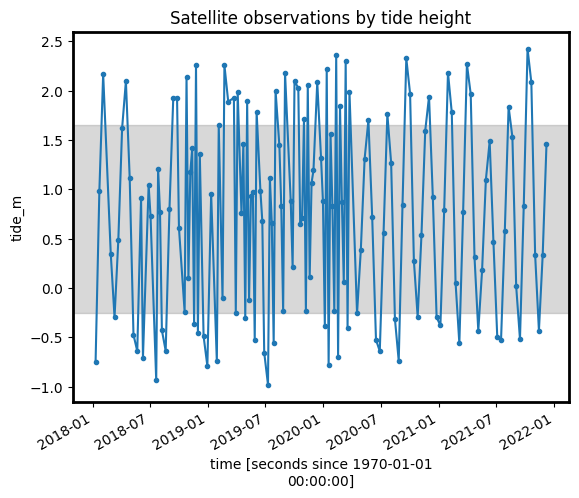

In [17]:
# Calculate the min and max tide heights to include based on the % range
min_tide, max_tide = S1.tide_m.quantile(tide_range) 

# Plot the resulting tide heights for each image:
S1.tide_m.plot(marker="o", markersize=3)
plt.axhspan(min_tide, max_tide, color='grey', alpha=0.3)
plt.title('Satellite observations by tide height')
plt.show()

### Filter scenes by tidal height range

In [18]:
# Keep timesteps larger than the min tide, and smaller than the max tide
S1_filtered = S1.sel(time=(S1.tide_m > min_tide) &
                                       (S1.tide_m <= max_tide))
print(S1_filtered)

<xarray.Dataset>
Dimensions:       (time: 72, y: 488, x: 387)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-22T02:35:29.013046 ... 2021-1...
  * y             (y) float64 -2.191e+06 -2.191e+06 ... -2.201e+06 -2.201e+06
  * x             (x) float64 4.234e+06 4.234e+06 ... 4.242e+06 4.242e+06
    spatial_ref   int32 6933
Data variables:
    vh            (time, y, x) float32 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    vv            (time, y, x) float32 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    mask          (time, y, x) float64 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    isAscending   (time, y, x) float64 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    isDescending  (time, y, x) float64 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    tide_m        (time) float64 0.9877 0.3492 0.4868 ... 0.3372 0.3393 1.46
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### Modelling tides for each pixel in a satellite time series

The previous examples show how to model a single tide height for each satellite image using the centroid of the image as a tide modelling location. However, in reality tides vary spatially, potentially up to several metres across a distance of kilometres in areas of complex tidal dynamics. This means that an individual satellite image can contain a range of tide height conditions.

To capture this spatial variability in tide heights, we can use the `pixel_tides` function. For each satellite timestep, this function models tide heights into a low-resolution 5 x 5 km grid (matching resolution of the [FES2014 tidal model](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html)), then reprojects modelled tides into the spatial extent of our satellite image. We add this new data as a new variable in our satellite dataset to allow each satellite pixel to be analysed and filtered/masked based on the tide height at the exact moment of satellite image acquisition. 

In [19]:
S1["tide_m"], tides_lowres = pixel_tides(S1, resample=True)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 145/145 [00:00<00:00, 357.06it/s]


If we plot the resulting data, we can see that we now have 2D tide surfaces for each timestep in our data (instead of the single tide height per timestamp returned by the `tidal_tag` function).

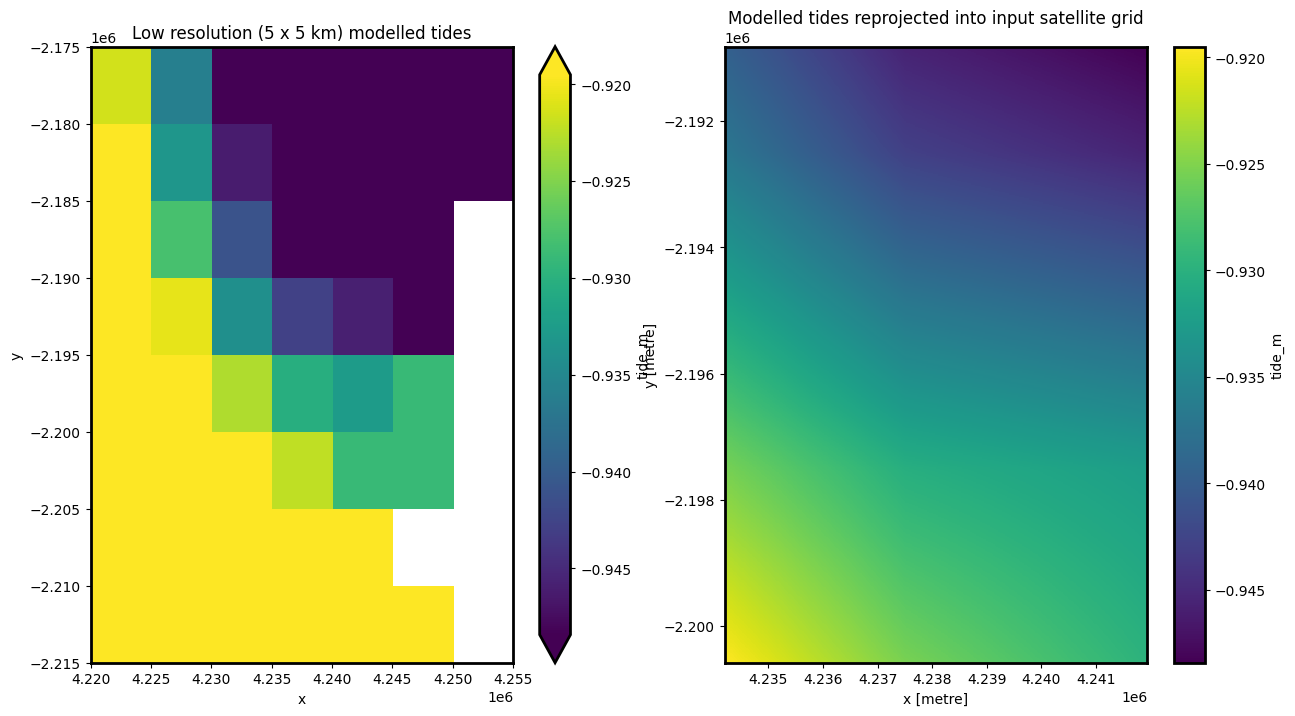

In [20]:
timestep = 15
ds_i = S1["tide_m"].isel(time=timestep)
ds_lowres_i = tides_lowres.isel(time=timestep)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
ds_lowres_i.plot.imshow(
    ax=axes[0],
    robust=True,
    cmap="viridis",
    vmin=ds_i.min().item(),
    vmax=ds_i.max().item(),
)
ds_i.plot.imshow(
    ax=axes[1],
    robust=True,
    cmap="viridis",
    vmin=ds_i.min().item(),
    vmax=ds_i.max().item(),
)
axes[0].set_title("Low resolution (5 x 5 km) modelled tides")
axes[1].set_title("Modelled tides reprojected into input satellite grid");

Based on the entire time-series of tide heights, we can compute the max and min satellite-observed tide height for each pixel, then calculate tide cutoffs used to restrict our data to satellite observations centred over mid-tide (0 m Above Mean Sea Level) using the `tide_cutoffs` function:

In [21]:
# Determine tide cutoff
tide_cutoff_min, tide_cutoff_max = tide_cutoffs(
    S1, tides_lowres, tide_centre=0.0
)

### Filter observations using calculated tide cutoffs  
With the tide cutoffs calculated for all pixels, we now only keep observations within the tide height cutoff ranges. We also want to drop time-steps with no pixels within the cutoff ranges:

In [22]:
tide_bool = (S1.tide_m >= tide_cutoff_min) & (
    S1.tide_m <= tide_cutoff_max
)
S1_filtered = S1.sel(time=tide_bool.sum(dim=["x", "y"]) > 0)

# Apply mask, and load in corresponding tide masked data
S1_filtered = S1_filtered.where(tide_bool)
print(S1_filtered)

<xarray.Dataset>
Dimensions:       (time: 75, y: 488, x: 387)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-10T02:35:29.430322 ... 2021-1...
  * y             (y) float64 -2.191e+06 -2.191e+06 ... -2.201e+06 -2.201e+06
  * x             (x) float64 4.234e+06 4.234e+06 ... 4.242e+06 4.242e+06
    spatial_ref   int32 6933
Data variables:
    vh            (time, y, x) float32 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    vv            (time, y, x) float32 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    mask          (time, y, x) float64 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    isAscending   (time, y, x) float64 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    isDescending  (time, y, x) float64 dask.array<chunksize=(1, 488, 387), meta=np.ndarray>
    tide_m        (time, y, x) float32 -0.7489 -0.7489 -0.749 ... 0.3321 0.3321
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Preprocessing Data
### Speckle Filtering using Lee Filter  
Radar observations appear speckly due to random interference of coherent signals from target scatters. The speckle noise can be reduced by averaging pixel values over an area or over time. However, averaging over a fixed window smoothes out real local spatial variation and leads to reduced spatial resolution. An adaptive approach that takes into account local homogeneity is therefore preferred.
Below, we apply the Lee filter, one of the popular adaptive speckle filters. The filtering might take a few minutes to finish.

In [23]:
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output

In [ ]:
# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
valid = xr.ufuncs.isfinite(S1)
S1 = S1.where(valid, 0)

if lee_filtering==True: # do filtering
    # Create a new entry in dataset corresponding to filtered VV and VH data
    S1["filtered_vh"] = S1.vh.groupby("time").apply(lee_filter, size=filter_size)
else: # don't do filtering
    S1["filtered_vh"]=S1["vh"]

# Null pixels should remain null
S1['filtered_vh'] = S1.filtered_vh.where(S1.filtered_vh!=0,np.nan)

>**Note**: As we will combine multi-temporal images to extract annual coastlines, speckle noise will be reduced through the temporal composite. Therefore, we recommend a small filtering size to minimise spatial resolution reduction. If you choose not to apply the filtering, you can set `lee_filtering` as `False`.

### Scale to plot data in decibels
While Sentinel-1 backscatter is provided as linear intensiy, it is often useful to convert the backscatter to decible (dB) for analysis. Backscatter in dB unit has a more symmetric noise profile and less skewed value distribution for easier statistical evaluation.

In [25]:
S1['filtered_vh'] = 10 * xr.ufuncs.log10(S1.filtered_vh)

## Automatic thresholding for shoreline extraction

### Plot histogram of filtered values
Backscatter distributions are plotted below as histograms.

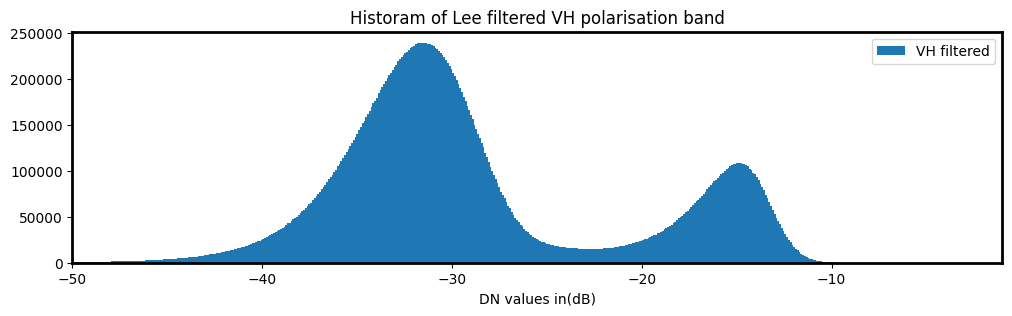

In [26]:
fig = plt.figure(figsize=(12, 3))
S1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
plt.xlim(-50,-1)
plt.legend()
plt.xlabel("DN values in(dB)")
plt.title("Historam of Lee filtered VH polarisation band");

The histogram for VH backscatter shows a bimodal distribution with low values over water and high values over land. We choose a threshold to separate land and water: pixels with values below the threshold are water, and pixels with values above the threshold are not water (land).

There are several ways to determine the threshold. The `threshold_minimum` and `threshold_otsu` functions in the skimage package implement minimum and Otsu’s thresholding methods respectively. The Otsu’s method calculates an optimal threshold by maximising the variance between two classes of pixels, which are separated by the threshold. Equivalently, this threshold minimizes the intra-class variance. The minimum thresholding method computes the histogram for all backscatter values, smooths it until there are only two maxima and find the minimum in between as the threshold.

In [28]:
# minimum thresholding
threshold_vh = threshold_minimum(S1.filtered_vh.values[~np.isnan(S1.filtered_vh.values)])
# otsu thresholding
threshold_vh_o = threshold_otsu(S1.filtered_vh.values[~np.isnan(S1.filtered_vh.values)])
print('threshold identified by minimum thresholding method: ',threshold_vh)
print('threshold identified by otsu thresholding method: ', threshold_vh_o)

threshold identified by minimum thresholding method:  -22.48691
threshold identified by otsu thresholding method:  -24.679962


To check if our chosen threshold reasonably divides the two distributions, we can add the thresholds to the histogram plots we made earlier. The green area indicate inconsistent classifications using the two methods.

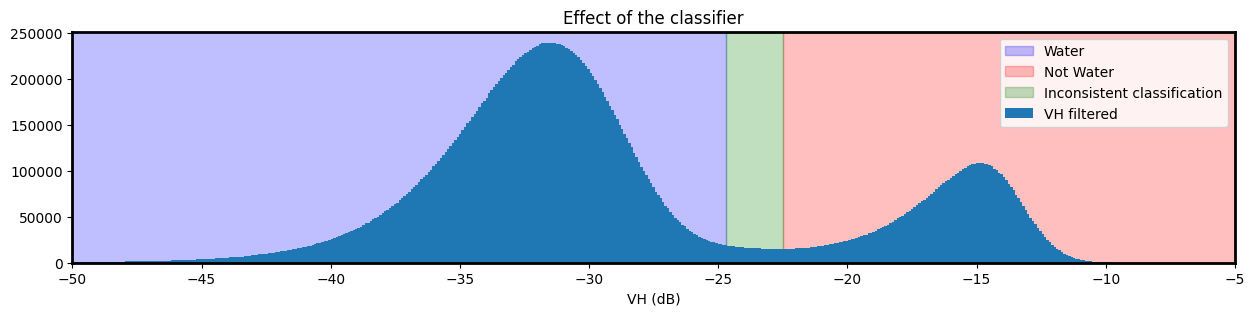

In [29]:
fig, ax = plt.subplots(figsize=(15, 3))
plt.xlim(-50,-5)
ax.axvspan(xmin=-50.0, 
           xmax=np.min([threshold_vh,threshold_vh_o]), 
           alpha=0.25, 
           color="blue", 
           label="Water")
ax.axvspan(xmin=np.max([threshold_vh,threshold_vh_o]),
           xmax=-5,
           alpha=0.25,
           color="red",
           label="Not Water")
ax.axvspan(xmin=np.min([threshold_vh,threshold_vh_o]),
           xmax=np.max([threshold_vh,threshold_vh_o]),
           alpha=0.25,
           color="green",
           label="Inconsistent classification")
S1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Effect of the classifier")
plt.show()

## Combine observations into noise-free summary images
Individual remote sensing images can be affected by noisy data, e.g. effects of wind on the water. To produce cleaner images that can be compared more easily across time, we can create 'summary' images or composites that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. In this case, we use the median as the summary statistic because it prevents strong outliers from skewing the data, which would not be the case if we were to use the mean.

In the code below, we take the time series of images and combine them into single images for each `time_step`. For example, if `time_step = '2Y'`, the code will produce one new image for each two-year period in the dataset. This step can take **several minutes to load** if the study area is large.

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

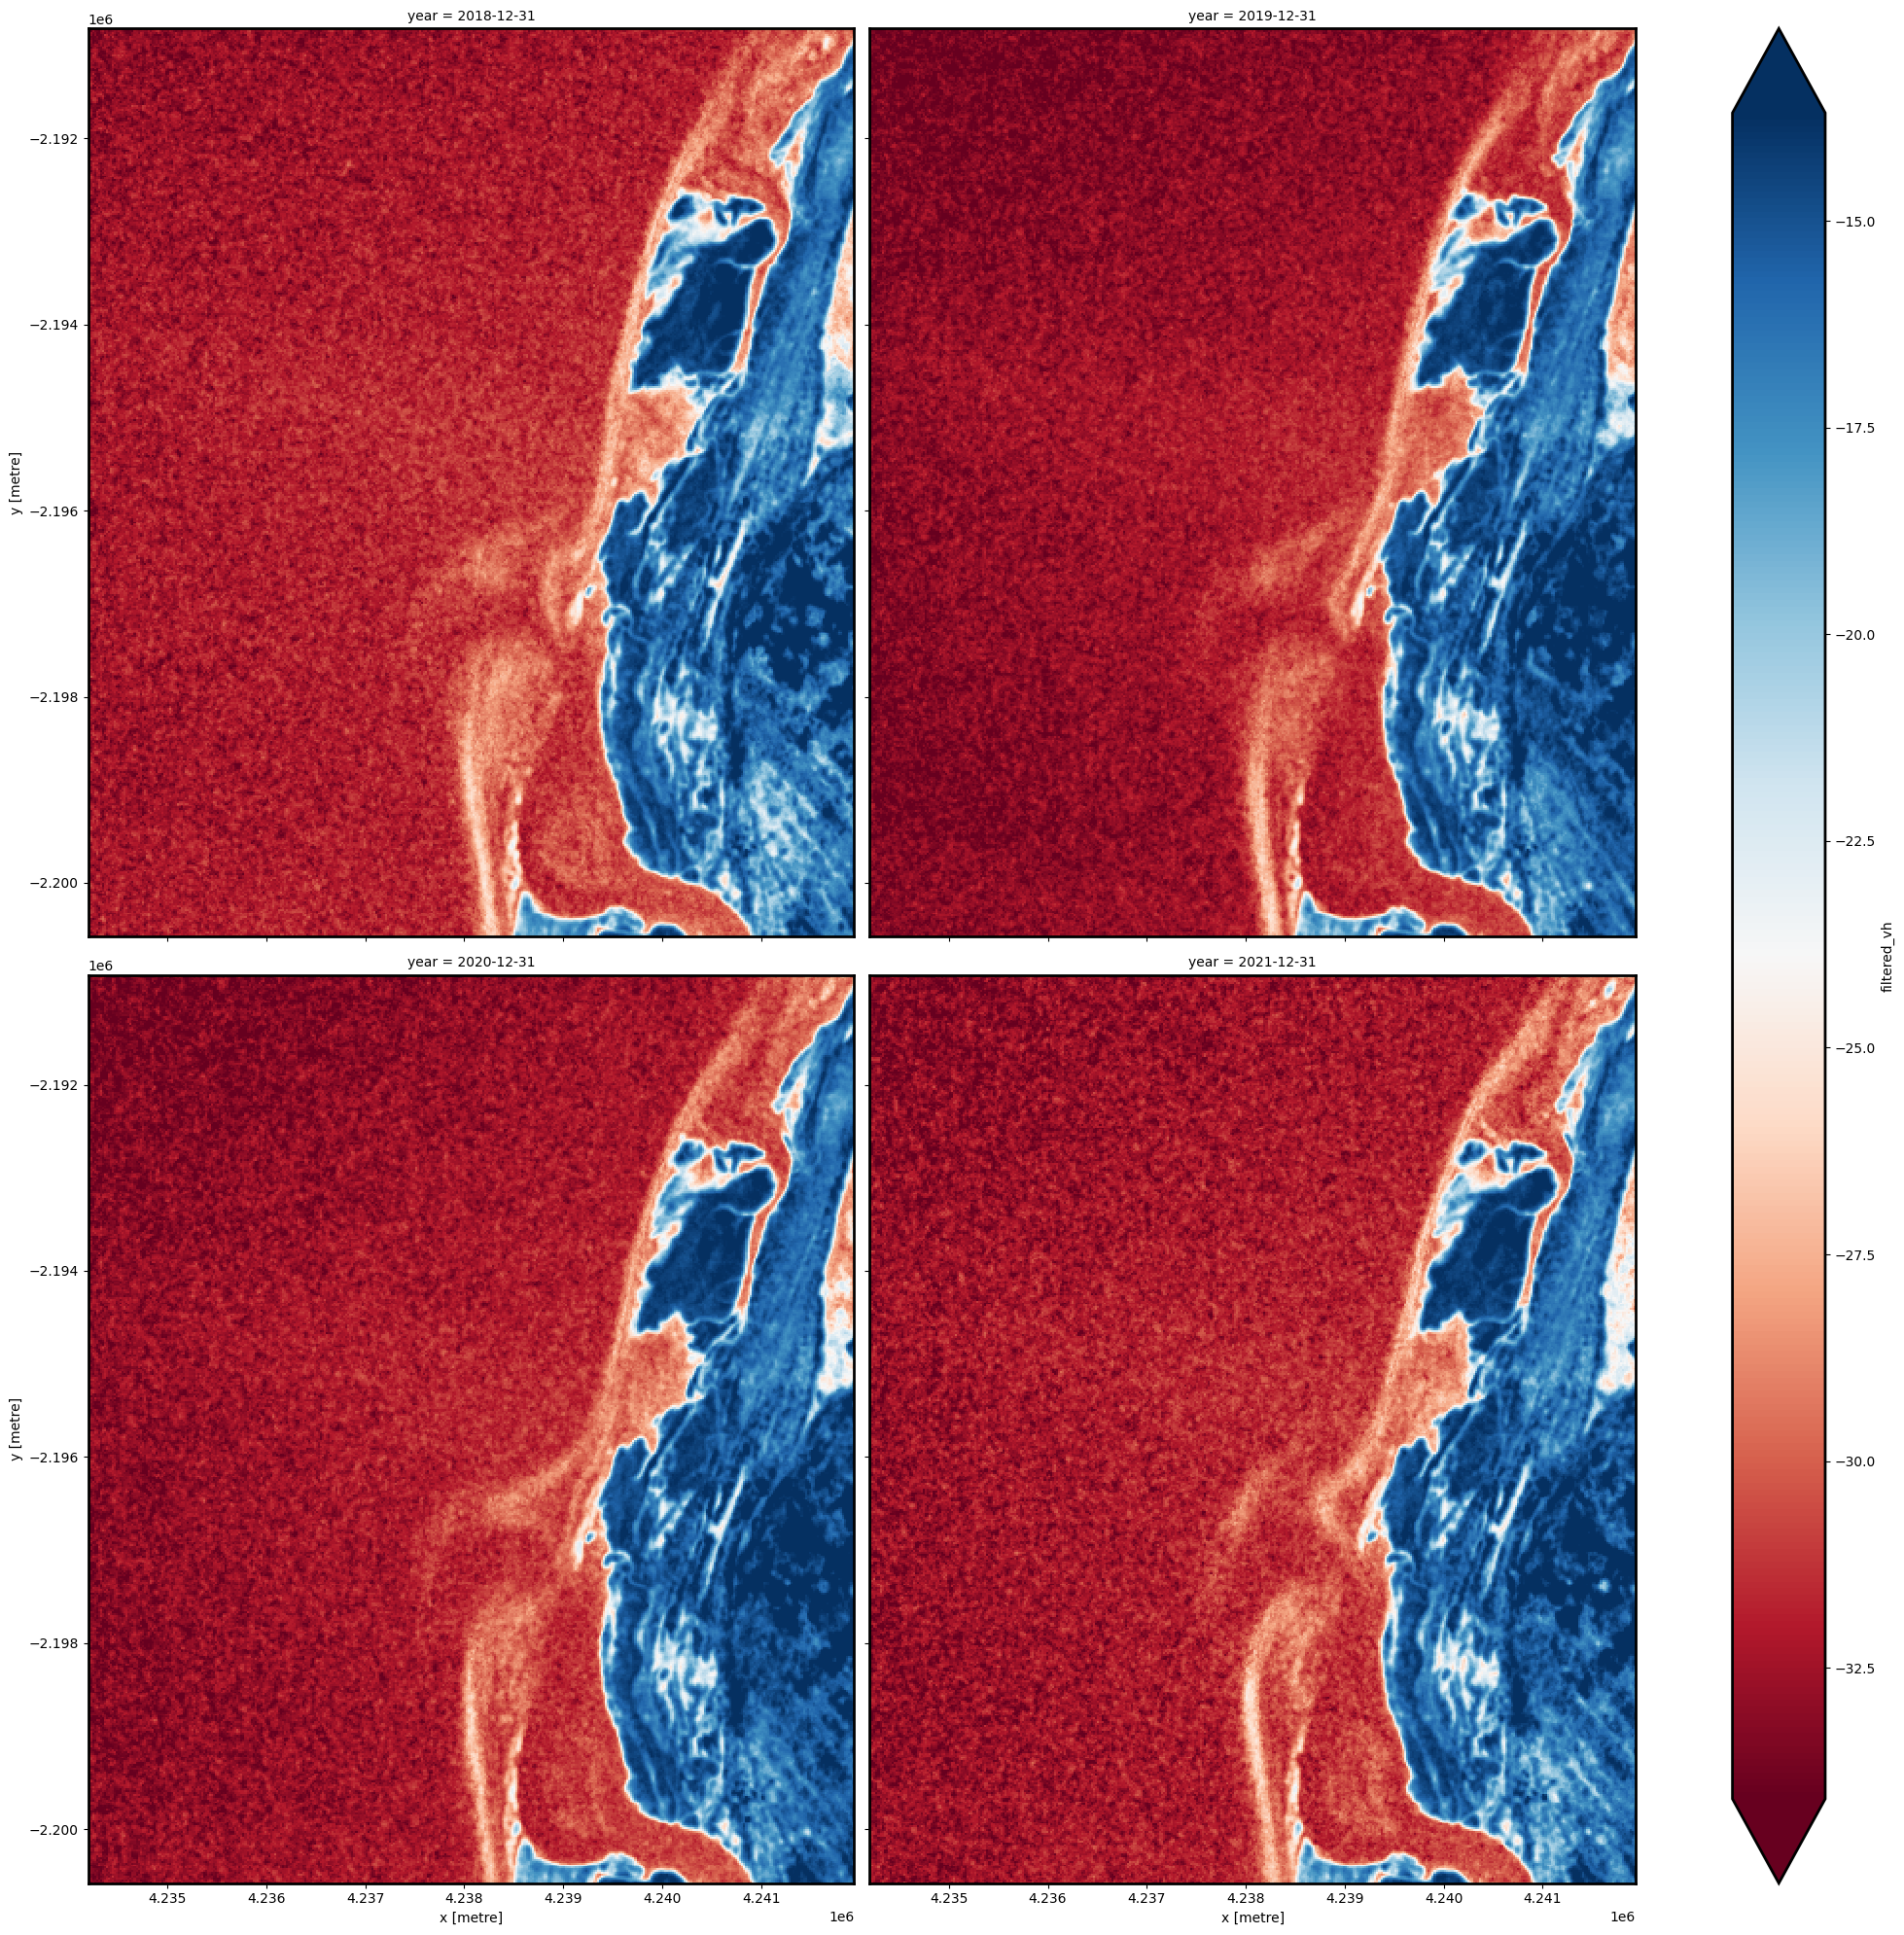

In [33]:
# Combine into summary images by `time_step`
ds_summaries = (S1[['filtered_vh']]
                     .resample(time=time_step)
                     .median('time')
                     .compute()
                    )
# Rename time attribute as year
ds_summaries = ds_summaries.rename(time='year')
    
# Plot the output summary images
ds_summaries.filtered_vh.plot(
                        col='year',
                       cmap='RdBu',
                       col_wrap=2,
                       robust=True, size=10)
plt.show()


In [34]:
# Shut down Dask client now that we have processed the data we need
client.close()

## Extract shorelines from imagery
We now want to extract an accurate shoreline for each of the summary images above. Here we use the threshold derived from the minimum thresholding as an example.
The code below identifies the boundary between land and water by tracing a line along pixels with the previously identified threshold value. 
It returns a vector file with one line for each time step:


In [37]:
contour_gdf = subpixel_contours(da=ds_summaries.filtered_vh,
                                z_values=threshold_vh,
#                                 z_values=threshold_vh_o,
                                dim='year',
                                crs=S1.geobox.crs,
                                affine=S1.geobox.transform,
                                output_path=f'annual_shorelines_S1.geojson',
                                min_vertices=15)
contour_gdf=contour_gdf.set_index('year')
# Preview shoreline data
contour_gdf

geometry
year                                                         
2018-12-31  MULTILINESTRING ((4240914.763 -2200570.000, 42...
2019-12-31  MULTILINESTRING ((4240920.026 -2200570.000, 42...
2020-12-31  MULTILINESTRING ((4240921.054 -2200570.000, 42...
2021-12-31  MULTILINESTRING ((4240925.302 -2200570.000, 42...

### Plot resampled shorelines on an interactive map
The next cell provides an interactive map with an overlay of the shorelines identified in the previous cell. Run it to view the map (this step can take **several minutes to load** if the study area is large).

Zoom in to the map below to explore the resulting set of shorelines. 
Older shorelines are coloured in black, and more recent shorelines in yellow.
Hover over the lines to see the time period for each shoreline printed above the map.
Using this data, we can easily identify areas of coastline or rivers that have changed significantly over time, or areas that have remained stable over the entire time period. 


In [39]:
# Plot shorelines on interactive map
contour_gdf.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI WorldImagery')

## Calculate rates of coastal change
To identify parts of the coastline that are changing rapidly, we can use our annual shoreline data to calculate rates of coastal change in metres per year.
This can be particularly useful to reveal hotspots of coastal retreat (e.g. erosion), or hotspots of coastal growth.

To do this, we first need to create a set of evenly spaced points at every 30 metres along the most recent shoreline in our dataset. 
These points will be used to plot rates of coastal change across our study area.

In [40]:
# Extract points at every 30 metres along the most recent shoreline
points_gdf = points_on_line(contour_gdf, index='2021', distance=20)
points_gdf.plot()

KeyError: "None of [Index(['2021'], dtype='object', name='year')] are in the [index]"

Now that we have a set of modelling points, we can measure distances from each of the points to each annual shoreline. 
This gives us a table of distances, where negative values (e.g. `-6.5`) indicate that an annual shoreline was located inland of our points, and positive values (e.g. `2.3`) indicate a shoreline was located towards the ocean. Because our points were created along our most recent 2021 shoreline, distances for 2021 will always have a distance of 0 m.

In [77]:
# For each 30 m-spaced point, calculate the distance from
# the most recent 2021 shoreline to each other annual shoreline
# in the datasets.
points_gdf = annual_movements(points_gdf,
                              contours_gdf=contour_gdf,
                              yearly_ds=ds_summaries,
                              baseline_year=2021,
                              water_index='filtered_vh')
points_gdf

geometry  dist_2018  dist_2019  dist_2020  \
0     POINT (4216902.598 -1564930.000)      -3.61      -3.54      -4.58   
1     POINT (4216899.800 -1564949.803)      -0.47      -1.96      -2.27   
2     POINT (4216897.625 -1564969.685)      -1.28       1.00      -0.94   
3     POINT (4216893.727 -1564989.300)      -1.09       1.82      -1.77   
4     POINT (4216892.815 -1565009.270)       3.78       3.40      -2.64   
...                                ...        ...        ...        ...   
2004  POINT (4218729.343 -1572578.736)      -5.43      -0.81      -3.14   
2005  POINT (4218717.891 -1572594.854)      -4.73      -1.83      -4.30   
2006  POINT (4218711.567 -1572613.760)      -3.43      -2.18      -3.96   
2007  POINT (4218705.638 -1572632.477)      -2.26      -1.39      -6.01   
2008  POINT (4218692.719 -1572647.744)      -4.71      -5.62     -10.79   

      dist_2021  angle_mean  angle_std  
0           0.0         107         32  
1           0.0         106         33  
2           0.0         101         33  
3           0.0         103         33  
4           0.0         100         34  
...         ...         ...        ...  
2004        0.0         135         24  
2005        0.0         114         31  
2006        0.0         108         32  
2007        0.0         118         31  
2008        0.0         137         23  

[2009 rows x 7 columns]

Finally, we can calculate annual rates of coastal change (in metres per year) using linear regression. 
This will add several new columns to our table:

* `rate_time`: Annual rates of change (in metres per year) calculated by linearly regressing annual shoreline distances against time (excluding outliers; see `outl_time`). Negative values indicate retreat and positive values indicate growth. 
* `sig_time`: Significance (p-value) of the linear relationship between annual shoreline distances and time. Small values (e.g. p-value < 0.01 or 0.05) may indicate a coastline is undergoing consistent coastal change through time. 
* `se_time`: Standard error (in metres) of the linear relationship between annual shoreline distances and time. This can be used to generate confidence intervals around the rate of change given by rate_time (e.g. 95% confidence interval = `se_time * 1.96`)
* `outl_time`: Individual annual shoreline are noisy estimators of coastline position that can be influenced by environmental conditions (e.g. clouds, breaking waves, sea spray) or modelling issues (e.g. poor tidal modelling results or limited clear satellite observations). To obtain reliable rates of change, outlier shorelines are excluded using a robust Median Absolute Deviation outlier detection algorithm, and recorded in this column. 

In [78]:
# Calculate rates of change using linear regression
points_gdf = calculate_regressions(points_gdf=points_gdf,
                                   contours_gdf=contour_gdf)
points_gdf

rate_time  sig_time  se_time outl_time  dist_2018  dist_2019  dist_2020  \
0         0.979     0.372    0.857                -3.61      -3.54      -4.58   
1         0.110     0.872    0.603                -0.47      -1.96      -2.27   
2         0.190     0.761    0.545                -1.28       1.00      -0.94   
3        -0.032     0.974    0.858                -1.09       1.82      -1.77   
4        -1.738     0.261    1.121                 3.78       3.40      -2.64   
...         ...       ...      ...       ...        ...        ...        ...   
2004      1.396     0.264    0.909                -5.43      -0.81      -3.14   
2005      1.172     0.317    0.887                -4.73      -1.83      -4.30   
2006      0.851     0.376    0.754                -3.43      -2.18      -3.96   
2007      0.216     0.892    1.400                -2.26      -1.39      -6.01   
2008      0.896     0.738    2.338                -4.71      -5.62     -10.79   

      dist_2021  angle_mean  angle_std                          geometry  
0           0.0         107         32  POINT (4216902.598 -1564930.000)  
1           0.0         106         33  POINT (4216899.800 -1564949.803)  
2           0.0         101         33  POINT (4216897.625 -1564969.685)  
3           0.0         103         33  POINT (4216893.727 -1564989.300)  
4           0.0         100         34  POINT (4216892.815 -1565009.270)  
...         ...         ...        ...                               ...  
2004        0.0         135         24  POINT (4218729.343 -1572578.736)  
2005        0.0         114         31  POINT (4218717.891 -1572594.854)  
2006        0.0         108         32  POINT (4218711.567 -1572613.760)  
2007        0.0         118         31  POINT (4218705.638 -1572632.477)  
2008        0.0         137         23  POINT (4218692.719 -1572647.744)  

[2009 rows x 11 columns]

### Plot rates of coastal change on an interactive map
Now that we have calculated rates of coastal change, we can plot these on an interactive map to identify parts of the coastline that are retreating or growing over time.

When the map appears below, hover your mouse over the coloured dots that appear along the coastline for a summary of recent coastal change at those locations. 
Red dots represent locations that are retreating (e.g. erosion), and blue dots represent locations that are growing.

![coastal_change.jpg](../Supplementary_data/Coastal_erosion/coastal_change.jpg)

In [79]:
# Add human-friendly label for plotting
points_gdf['Coastal change'] = points_gdf.apply(
    lambda x:
    f'<h4>This coastline has {"<b>retreated</b>" if x.rate_time < 0 else "<b>grown</b>"} '
    f'by</br><b>{x.rate_time:.2f} m (±{x.se_time:.1f}) per year</b> since '
    f'<b>{contour_gdf.index[0]}</b></h4>',
    axis=1)
points_gdf.loc[points_gdf.sig_time > 0.05, 'Coastal change'] = (
    f'<h4>No significant trend of retreat or growth)</h4>')

# Add annual shorelines to map
m = contour_gdf.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    tooltip=False,
    style_kwds={'opacity': 0.5},
    attr='ESRI WorldImagery')

# Add rates of change to map
points_gdf.explore(
    m=m,
    column='rate_time',
    vmin=-5,
    vmax=5,
    tooltip='Coastal change',
    cmap='RdBu',
)

> **Important note:** This notebook may produce misleading rates of change for non-coastal waterbodies that might fluctuate naturally year-by-year.
The full [Digital Earth Africa Coastlines repository](https://github.com/digitalearthafrica/deafrica-coastlines.git) contains additional methods for producing more accurate rates of change by cleaning and filtering annual shoreline data to focus only on coastal shorelines.

### Export rates of change to file
Finally, we can export our output rates of change file so that it can be loaded in GIS software (e.g. ESRI ArcGIS or QGIS).

In [80]:
points_gdf.to_crs('EPSG:4326').to_file(output_path.replace('annual_shorelines','rates_of_changes'))

## Drawing conclusions
Here are some questions to think about:
* What can you conclude about the change in the shoreline? 
* Which sections of the shoreline have seen the most change? 
* Is the change consistent with erosion? 
* What other information might you need to draw additional conclusions about the cause of the change?

## Next steps
When you are done, return to the "Set up analysis" cell, modify some values (e.g. `time_range`, `tide_range`, `time_step` or `lat`/`lon`) and rerun the analysis.
If you're going to change the location, you'll need to make sure Sentinel-1 data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/products/). 

For more information about the method behind this notebook, read the scientific paper:
> Bishop-Taylor, R., Nanson, R., Sagar, S., Lymburner, L. (2021). Mapping Australia's dynamic coastline at mean sea level using three decades of Landsat imagery. Remote Sensing of Environment 267, 112734. Available: https://doi.org/10.1016/j.rse.2021.112734

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [81]:
print(datacube.__version__)

1.8.8


**Last Tested:**

In [82]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-05-25'